# Audio Data Pre-Processing [Sound Cloud]

## Part 1: Data Mining
You are given a soundscloud_urls.csv file containing URLs to SoundCloud.com. You are tasked with extracting the audio files, the name of the author and the track name from the provided links, save this data in a `.csv` and display the dataframe in your notebook. All audio file must be saved as `.wav` in the `./data` directory. 



### Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pydub import AudioSegment
import requests
import re
import os
import logging
import glob 
import librosa
import time
import librosa.display
import warnings
warnings.filterwarnings("ignore")

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

### Loading SoundCloud URLs

In [2]:
# When loading the csv file into pandas, it uses the top row (which was a URL) as the header by default 
# To solve this problem, I set the 'header' parameter to None and created a new column name called 'urls'
urls = pd.read_csv("soundscloud_urls.csv",header=None,names=['urls'])
urls

,urls
0,https://soundcloud.com/hyenrg/take-it-back
1,https://soundcloud.com/hyenrg/friction
2,https://soundcloud.com/djdssoulfulgeneration/s...
3,https://soundcloud.com/hyenrg/back-2-me
4,https://soundcloud.com/josephine-schmidt/rise-...
5,https://soundcloud.com/andre-roider/audiospektrum
6,https://soundcloud.com/hyenrg/feel-good-renegade
7,https://soundcloud.com/andre-roider/play
8,https://soundcloud.com/storyofthelie/free-hall...
9,https://soundcloud.com/djdssoulfulgeneration/s...


### Downloading Songs

In [3]:
df = pd.DataFrame(columns = ['URL','API Endpoint','Redirect URI','Song Id',
                             'Title','Author Name','Track Name'])

for index, url in urls.iterrows():    
    
    # creating data directory
    os.system("mkdir data")
    
    # using index as song number for logging purposes
    index+=1 
    
    # attempting to fetch html script
    try:
        html = requests.get(url['urls']).text
        logging.info(f"Song #{index} SoundCloud URL: {url['urls']}")
    
        # searching for title tag
        title_raw = re.search('<title>([^|]+) | Free Listening on SoundCloud</title>', html)
        title_raw = title_raw.group(1)
        logging.info(f"Song #{index} Title: {title_raw}")
        title = title_raw.split("Stream ")[1].split(" by ")

        # parsing title to get author name
        author_name = title[1].strip()
        logging.info(f"Song #{index} Author Name: {author_name}")

        # parsing title to get track name
        track_name = title[0].strip()
        logging.info(f"Song #{index} Track Name: {track_name}")

        # extracting song id from html script
        song_id = re.search(r'soundcloud://sounds:(\d+)', html)
        song_id = song_id.group(1)
        logging.info(f"Song #{index} Song Id: {song_id}")

        # by going to any track and looking at the payload of any endpoint call you can find your client id
        client_id = 'nzlp05ChzxSyVpcOCKvTIZdwDLZfWM0z'

        # fetch downloadable link from redirectUri of API (v2) endpoint response
        endpoint_url = f"https://api-v2.soundcloud.com/tracks/{song_id}/download?client_id={client_id}"
        logging.info(f"Song #{index} API Endpoint URL: {endpoint_url}")

        # downloading the song from the downloadable reply URL 
        redirect_uri = None          
        while redirect_uri is None:
            try:
                response = requests.request("GET", endpoint_url, headers={'content-type': "application/json"})
                redirect_uri = response.json()['redirectUri']
            except:
                 pass
        logging.info(f"Song #{index} Redirect URL: {redirect_uri}")

        # downloading song and saving it into data directory
        song = requests.request("GET",redirect_uri)
        open(f'data/{song_id}.mp3', 'wb').write(song.content)

        df = df.append({
            'URL': url['urls'],
            'API Endpoint': endpoint_url ,
            'Redirect URI': redirect_uri,
            'Song Id': song_id,                     
            'Title': title_raw,
            'Author Name': author_name,
            'Track Name': track_name,
        },ignore_index=True)

    # if link is not valid, continue...
    except requests.ConnectionError as exception:
        continue
    
    if index==2:
        break

2021-12-10 18:44:31,587 - Song #1 SoundCloud URL: https://soundcloud.com/hyenrg/take-it-back
2021-12-10 18:44:31,588 - Song #1 Title: Stream Take It Back by HyeNRG
2021-12-10 18:44:31,589 - Song #1 Author Name: HyeNRG
2021-12-10 18:44:31,590 - Song #1 Track Name: Take It Back
2021-12-10 18:44:31,591 - Song #1 Song Id: 1171193422
2021-12-10 18:44:31,592 - Song #1 API Endpoint URL: https://api-v2.soundcloud.com/tracks/1171193422/download?client_id=nzlp05ChzxSyVpcOCKvTIZdwDLZfWM0z
2021-12-10 18:44:32,009 - Song #1 Redirect URL: https://cf-media.sndcdn.com/dhvqqJGqdA9b?Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiKjovL2NmLW1lZGlhLnNuZGNkbi5jb20vZGh2cXFKR3FkQTliKiIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTYzOTE1NDc5Mn19fV19&Signature=YAe4GFg~JLazObL4pKBqy0ZzUPULPSYNy9~6qOTSw0HDoF7hVTF9biAyeP8xAWCcWLhMKxMEi02wJKA86O-imN8r3q4Zn~RjhLl33A~8jHS7-ZwEOdFUSixL5nurZ2hGXrxZL4E63ZnWUA62t5940zIR4M2ccvIUEwEWB-ZmewAKV~NzvKFqbTbrNA7KPQff96js9m1w2XxVGfcxiiakJOnhAn7MpBnxldat85p~OjNkbwz3Mb

In [4]:
df

,URL,API Endpoint,Redirect URI,Song Id,Title,Author Name,Track Name
0,https://soundcloud.com/hyenrg/take-it-back,https://api-v2.soundcloud.com/tracks/117119342...,https://cf-media.sndcdn.com/dhvqqJGqdA9b?Polic...,1171193422,Stream Take It Back by HyeNRG,HyeNRG,Take It Back
1,https://soundcloud.com/hyenrg/friction,https://api-v2.soundcloud.com/tracks/117119277...,https://cf-media.sndcdn.com/nDniq7ikftY9?Polic...,1171192777,Stream Friction by HyeNRG,HyeNRG,Friction


## Part 2: Data Processing and Visualization
Once you have downloaded your audio files, you are tasked with pre-processing your data by conversing the raw waveform to a spectrogram using the Fast Fourier Transform (FFT). You can find more information about the FFT [HERE](http://www.dspguide.com/ch12.htm)
Finally, your must convert your spectrogram from Hz range to the mel-scale. More information about me-scaling can be found [HERE](http://pdf-s3.xuebalib.com:1262/249gn34RBxh1.pdf)

**Note:** You are not permitted to use built-in functions to perform FFT and mel-scale operations mentioned in part 2. 

### Converting .mp3 to .wav

In [5]:
song = AudioSegment.from_mp3("data/1171192777.mp3")
song.export("data/1171192777.wav", format="wav")

<_io.BufferedRandom name='data/1171192777.wav'>

### Loading .wav file

In [6]:
x, sampling_rate = librosa.load("data/1171192777.wav")

print(x.shape, sampling_rate)

(7378560,) 22050


### Visualizing Song Waveform

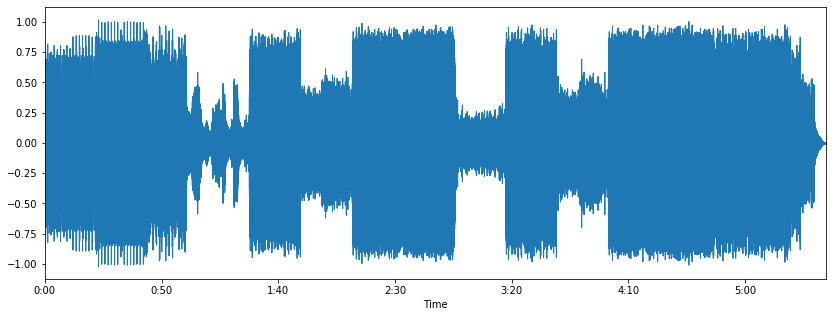

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sampling_rate)

### Discrete Fourier Transform

\begin{equation}
X[k] = \sum_{n = 0}^{N-1} x[n] \, \;  \mathrm{e}^{\,-\mathrm{2j}\,\frac{\pi}{N} k n}
\end{equation}

In [8]:
def discrete_fourier_transform(x):
    # getting the total number of samples (input array shape)
    N = np.asarray(x, dtype=float).shape[0]
    
    # getting the current sample
    n = np.arange(N)
    
    # getting the current frequency
    k = n.reshape((N, 1))
    
    # applying the exponential calculation as defined above
    exponent = np.exp(-2j * (np.pi / N) * k * n)
    
    # returning dot product of the two resultant arrays
    return np.dot(exponent, x)

### Fast Fourier Transform [Recursive Implementation]

I implemented the Fast Fourier Transform (FFT) algorithm in a divide and conquer fashion. I recursively split the input array into two parts: one for the odd indices, and another for the even indices, until N<=1 is acheived. 

$F(k) = \sum_{x=0}^{N-1} f(x)W_N^{kx}$

After splitting the even indices ($2x$) and the odd indices ($2x+1$):

$F(k) = \sum_{x = 0}^{N/2-1} f(2x)W_N^{k(2x)} +  \sum_{x =0}^{N/2-1} f(2x+1)W_N^{k(2x+1)}$


In [9]:
def fast_fourier_transform(x):
    # getting the total number of samples (input array shape)
    N = np.asarray(x, dtype=float).shape[0]
    
    # checking if trivial case is reached
    if N <= 1:
        return x
    
    # dividing
    even_indices = fast_fourier_transform(x[0::2])
    odd_indices = fast_fourier_transform(x[1::2])

    # storing results
    results = np.zeros(N)
    
    for k in range(N // 2):
        results[k] = even_indices[k] + np.exp(-2j * np.pi * k/ N) * odd_indices[k] # conquer
        results[k + N // 2] = even_indices[k] - np.exp(-2j * np.pi * k/ N) * odd_indices[k]  # conquer
                
    return results

### DFT vs FFT [Run Time]

In [10]:
start = time.time()
X_dft = discrete_fourier_transform(x[0:10000])
end = time.time()
print("DFT Running time: " + str(end - start) + " seconds")

start = time.time()
X_fft = fast_fourier_transform(x[0:10000])
end = time.time()
elapsed = end - start
print("FFT Running time: " + str(end - start) + " seconds")

DFT Running time: 4.44479513168335 seconds
FFT Running time: 0.9829549789428711 seconds


### Plotting Spectrogram

In [11]:
# calculating the frequency (Hz)
N = np.asarray(X_fft, dtype=float).shape[0]
sample = np.arange(N)
wave_period = len(X_fft)/sampling_rate
freq_hz = sample/wave_period

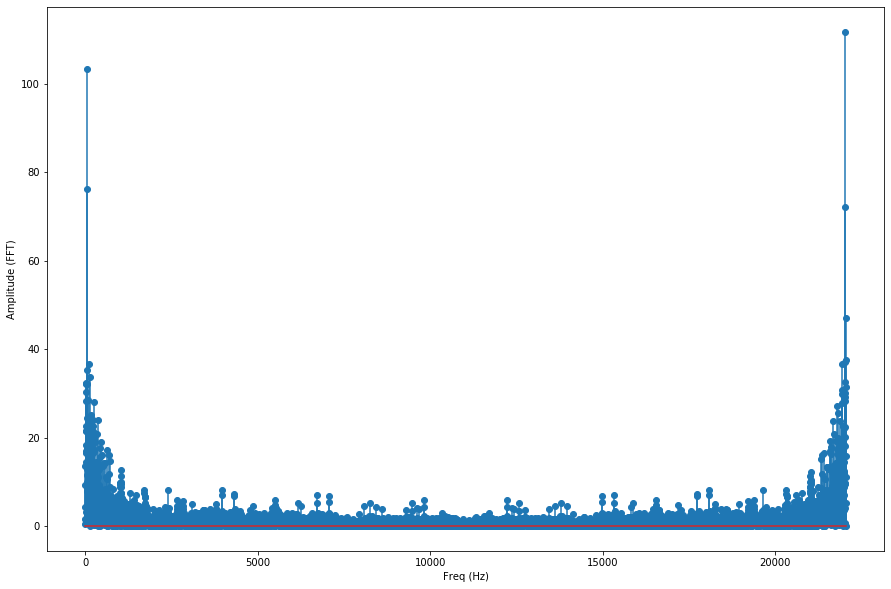

In [12]:
# plotting Ampliture (FFT) / frequency (Hz) plot
plt.figure(figsize = (15, 10))
plt.stem(freq_hz, abs(X_fft))
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude (FFT)')
plt.show()

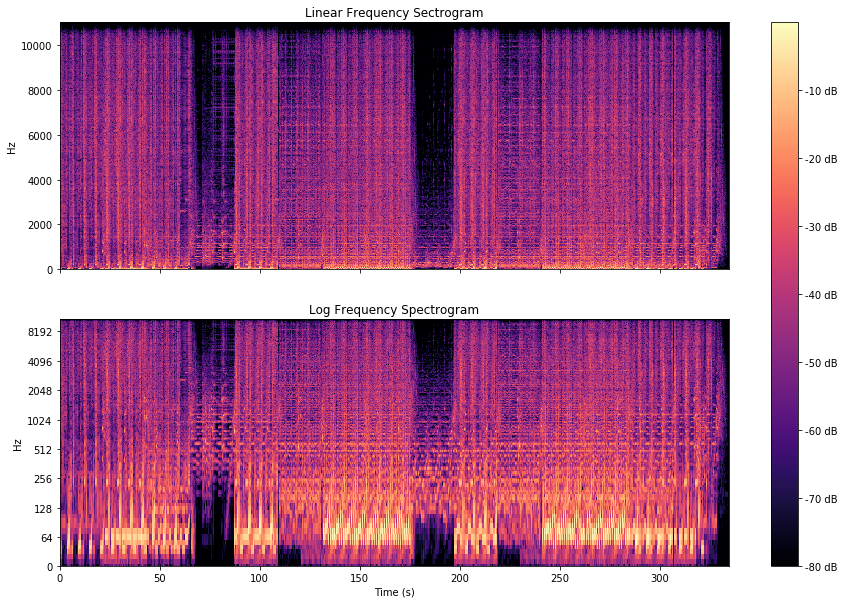

In [13]:
# Using librosa's STFT function instead of my FFT funtion 
# since mine wascrashing due to a kernel/memory error
X = librosa.stft(x)

# convert an amplitude spectrogram to db-scaled spectrogram.
X_db = librosa.amplitude_to_db(abs(X),ref=np.max)

# plotting linear frequency spectrogram
fig,ax = plt.subplots(2,1,sharex=True,figsize=(15,10))
img = librosa.display.specshow(X_db, y_axis='linear', x_axis='s',sr=sampling_rate,ax=ax[0])
ax[0].set(title='Linear Frequency Sectrogram')

# plotting log frequency spectrogram
ax[0].label_outer()
librosa.display.specshow(X_db, y_axis='log', x_axis='s', sr=sampling_rate, ax=ax[1])
ax[1].set(title='Log Frequency Spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format='%+2.f dB')

### Mapping Frequency (Hz) onto the Mel-Scale

\begin{equation}
mel = 1/log(2) * (log(1 + (Hz/1000))) * 1000
\end{equation}

In [14]:
# defining Hz to Mel conversion
hz_mel = lambda t: 1/np.log(2) * (np.log(1+(t/1000))) * 1000

In [15]:
# calculating the frequency (Hz)
N = np.asarray(X_fft, dtype=float).shape[0]
sample = np.arange(N)
wave_period = len(X_fft)/sampling_rate
freq_hz = sample/wave_period

In [16]:
# converting frequency from Hz to Mel
freq_mel = hz_mel(freq_hz)

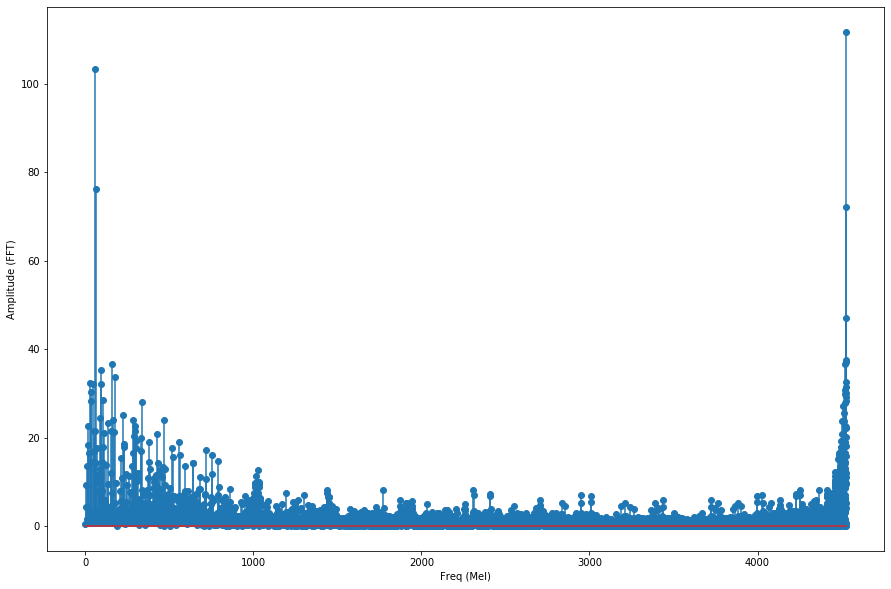

In [17]:
# plotting Ampliture (FFT) / frequency (Hz) plot
plt.figure(figsize = (15, 10))
plt.stem(freq_mel, abs(X_fft))
plt.xlabel('Freq (Mel)')
plt.ylabel('Amplitude (FFT)')
plt.show()

### Plotting Mel Spectrogram

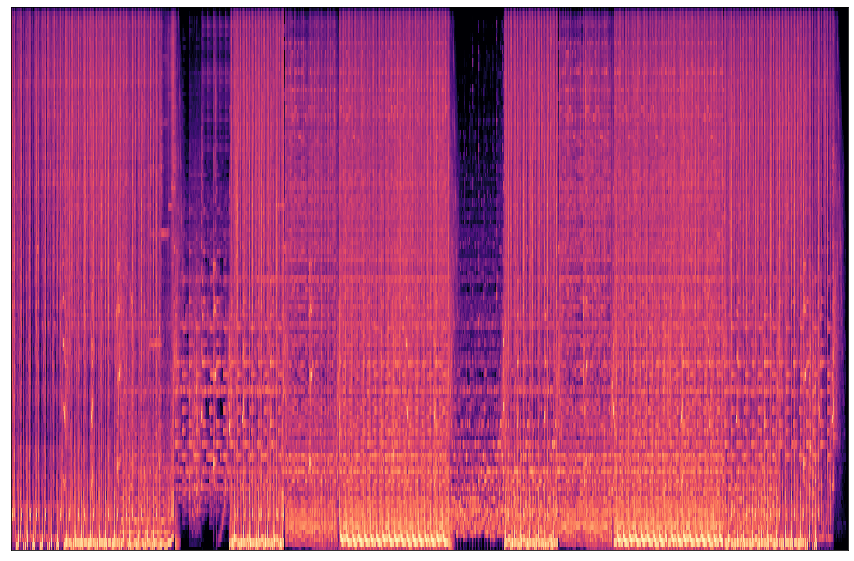

In [18]:
# setting figure size
plt.figure(figsize = (15, 10))

# plotting mel-spectrogram
mel_spec = librosa.feature.melspectrogram(y=x, sr=sampling_rate)
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max))
plt.show()